## Data Exploration

**1. Find our experiment records**

In [1]:
!rm data/.DS_Store
from os import listdir
from os.path import isfile, join
data_raw = [f for f in listdir("data2") if isfile(join("data2", f))]
print(len(data_raw), "files:", str(data_raw))

rm: data/.DS_Store: No such file or directory
15 files: ['56.6.csv', '46.8.csv', '21.8.csv', '18.3.csv', '40.7.csv', '27.3.csv', '46.7.csv', '53.8.csv', '13.9.csv', '58.6.csv', '33.8.csv', '22.1.csv', '19.7.csv', '24.4.csv', '39.1.csv']


**2. Save into a dictionary**

In [2]:
import csv
import numpy as np
data = {}
for experiment in data_raw:
    t, temp = [], []
    with open("data2/"+experiment) as csvfile:
        print(experiment)
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            t.append(int(row[0])/1e3)
            temp.append(float(row[1]))
        data[experiment[:-4]] = (np.array(t)[:200], np.array(temp)[:200])

56.6.csv
46.8.csv
21.8.csv
18.3.csv
40.7.csv
27.3.csv
46.7.csv
53.8.csv
13.9.csv
58.6.csv
33.8.csv
22.1.csv
19.7.csv
24.4.csv
39.1.csv


**3. Plot**

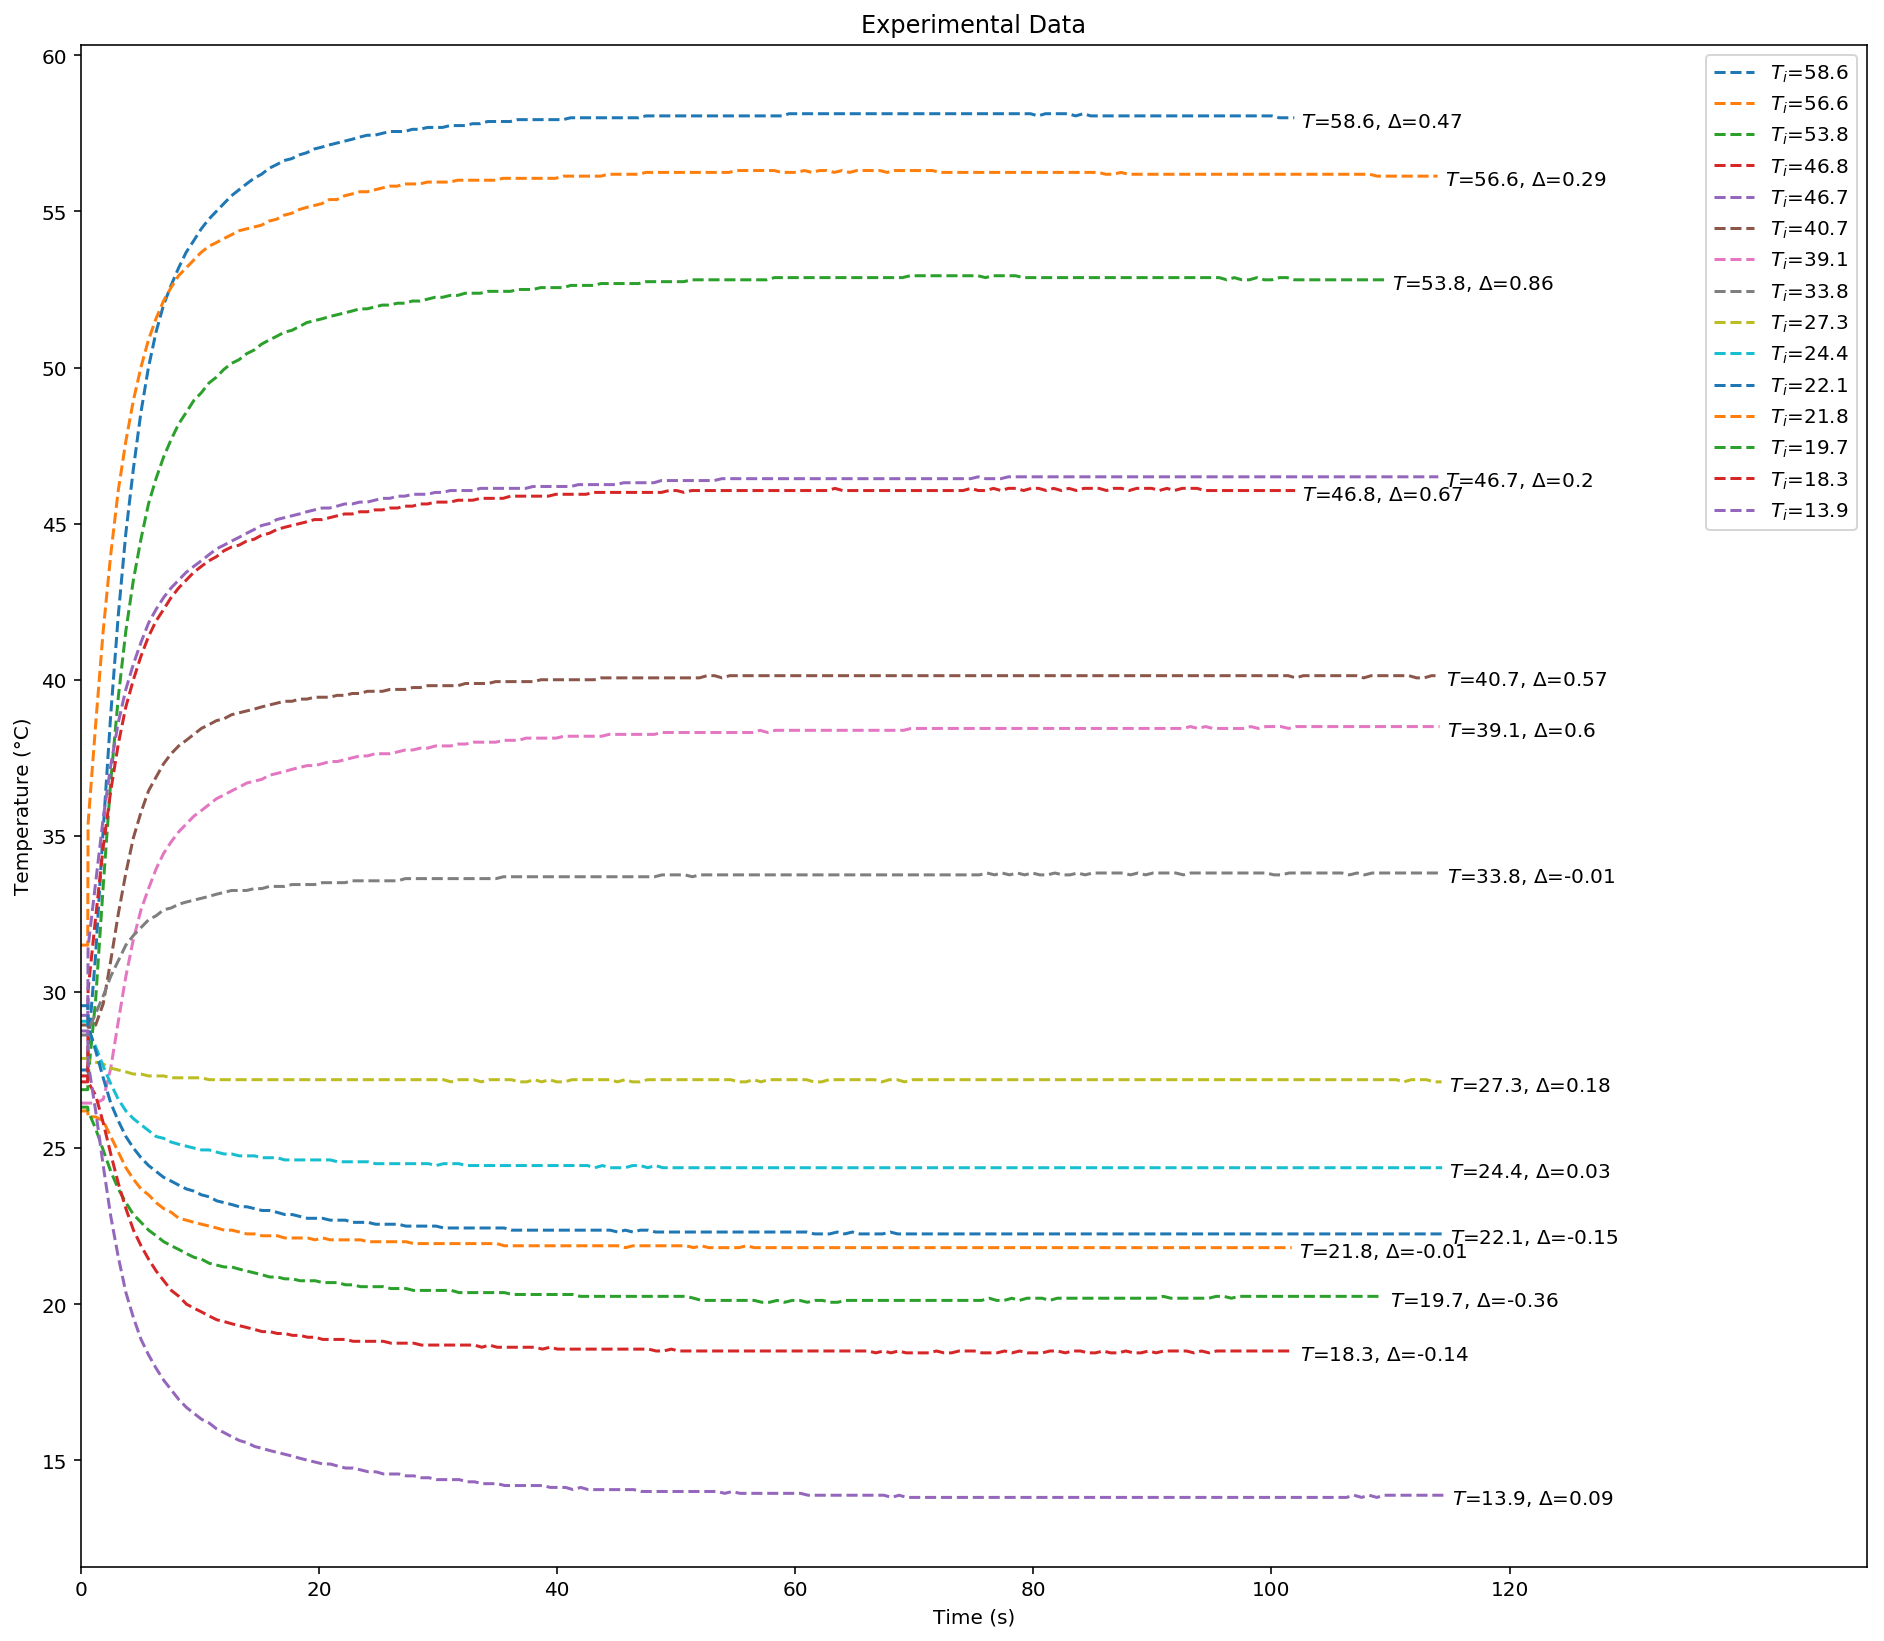

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.figure(1, figsize=(16, 14))
plt.title("Experimental Data")
plt.xlabel("Time (s)")
plt.xticks(np.arange(0, 130, step=20))
plt.xlim(0,150)
plt.yticks(np.arange(0, 61, step=5))
plt.ylabel("Temperature (°C)")
ordered_experiments = list(data.keys())
ordered_experiments.sort()
for experiment in ordered_experiments[::-1]:
    t, temp = data[experiment]
    plt.plot(t, temp, '--', label=r"$T_i$="+experiment)
    if float(experiment) < 28:
        label = round(float(experiment) - temp.min(), 2)
    else:
        label = round(float(experiment) - temp.max(), 2)
    plt.text(t[-1]+0.6,temp[-1]-0.3, r"$T$="+experiment+r", $\Delta$="+str(label))
    #plt.axhline(y=float(experiment), linestyle='--')
plt.legend()
plt.show()

In [4]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import *
from keras.layers import *
def normalise_values(train_x, train_y):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_x)
    scaled_x = scaler.transform(train_x)
    scaled_x = scaled_x.reshape(scaled_x.shape[0], 1, scaled_x.shape[1])

    scaler = scaler.fit(train_y)
    scaled_y = scaler.transform(train_y)
    scaled_y = scaled_y.reshape(scaled_y.shape[0],scaled_y.shape[1])
    
    return scaled_x[:160], scaled_y[:160]

train_x = data["58.6"][1][:-1].reshape(-1, 1)
train_y = data["58.6"][1][1:].reshape(-1, 1)
scaled_x, scaled_y = normalise_values(train_x, train_y)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.


In [5]:
"""model = Sequential()
model.add(LSTM(20, batch_input_shape=(1, scaled_x.shape[1], scaled_x.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mae', 'acc'])"""

"model = Sequential()\nmodel.add(LSTM(20, batch_input_shape=(1, scaled_x.shape[1], scaled_x.shape[2]), stateful=True))\nmodel.add(Dense(1))\nmodel.compile(loss='mean_squared_error', optimizer='adam',metrics=['mae', 'acc'])"

In [6]:
sequence_input = Input(batch_shape=(1,scaled_x.shape[1], scaled_x.shape[2]), dtype='float32')
lstm_1 = LSTM(20,return_sequences=False, stateful=True)(sequence_input)
output = Dense(1)(lstm_1)
model = Model(sequence_input, output)
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mae', 'acc'])
model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (1, 1, 1)                 0         
_________________________________________________________________
lstm_1 (LSTM)                (1, 20)                   1760      
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [7]:
#for layer in model.layers:
#    print(layer.name)

In [8]:
for layer in model.layers:
    layer.trainable = True
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mae', 'acc'])

for i in range(1):
    for experiment in data.keys():
        if float(experiment) > 45:
            print(experiment, end=": ")
            train_x = data[experiment][1][:-1].reshape(-1, 1)
            train_y = data[experiment][1][1:].reshape(-1, 1)
            scaled_x, scaled_y = normalise_values(train_x, train_y)
            model.fit(scaled_x, scaled_y, epochs=1, batch_size=1, verbose=1, shuffle=False)
            model.reset_states()

56.6: Epoch 1/1
160/160 [==============================] - 0s - loss: 0.2044 - mean_absolute_error: 0.3042 - acc: 0.1250       
46.8: Epoch 1/1
160/160 [==============================] - 0s - loss: 0.0875 - mean_absolute_error: 0.1362 - acc: 0.1875     
46.7: Epoch 1/1
160/160 [==============================] - 0s - loss: 0.0563 - mean_absolute_error: 0.1127 - acc: 0.2062     
53.8: Epoch 1/1
160/160 [==============================] - 0s - loss: 0.0455 - mean_absolute_error: 0.0884 - acc: 0.1812     
58.6: Epoch 1/1
160/160 [==============================] - 0s - loss: 0.0375 - mean_absolute_error: 0.0813 - acc: 0.3312     


6.929
6.294
6.299
6.3
6.299
6.303
6.306
6.305
6.308
6.309
6.31
6.313
6.314
6.314
6.316


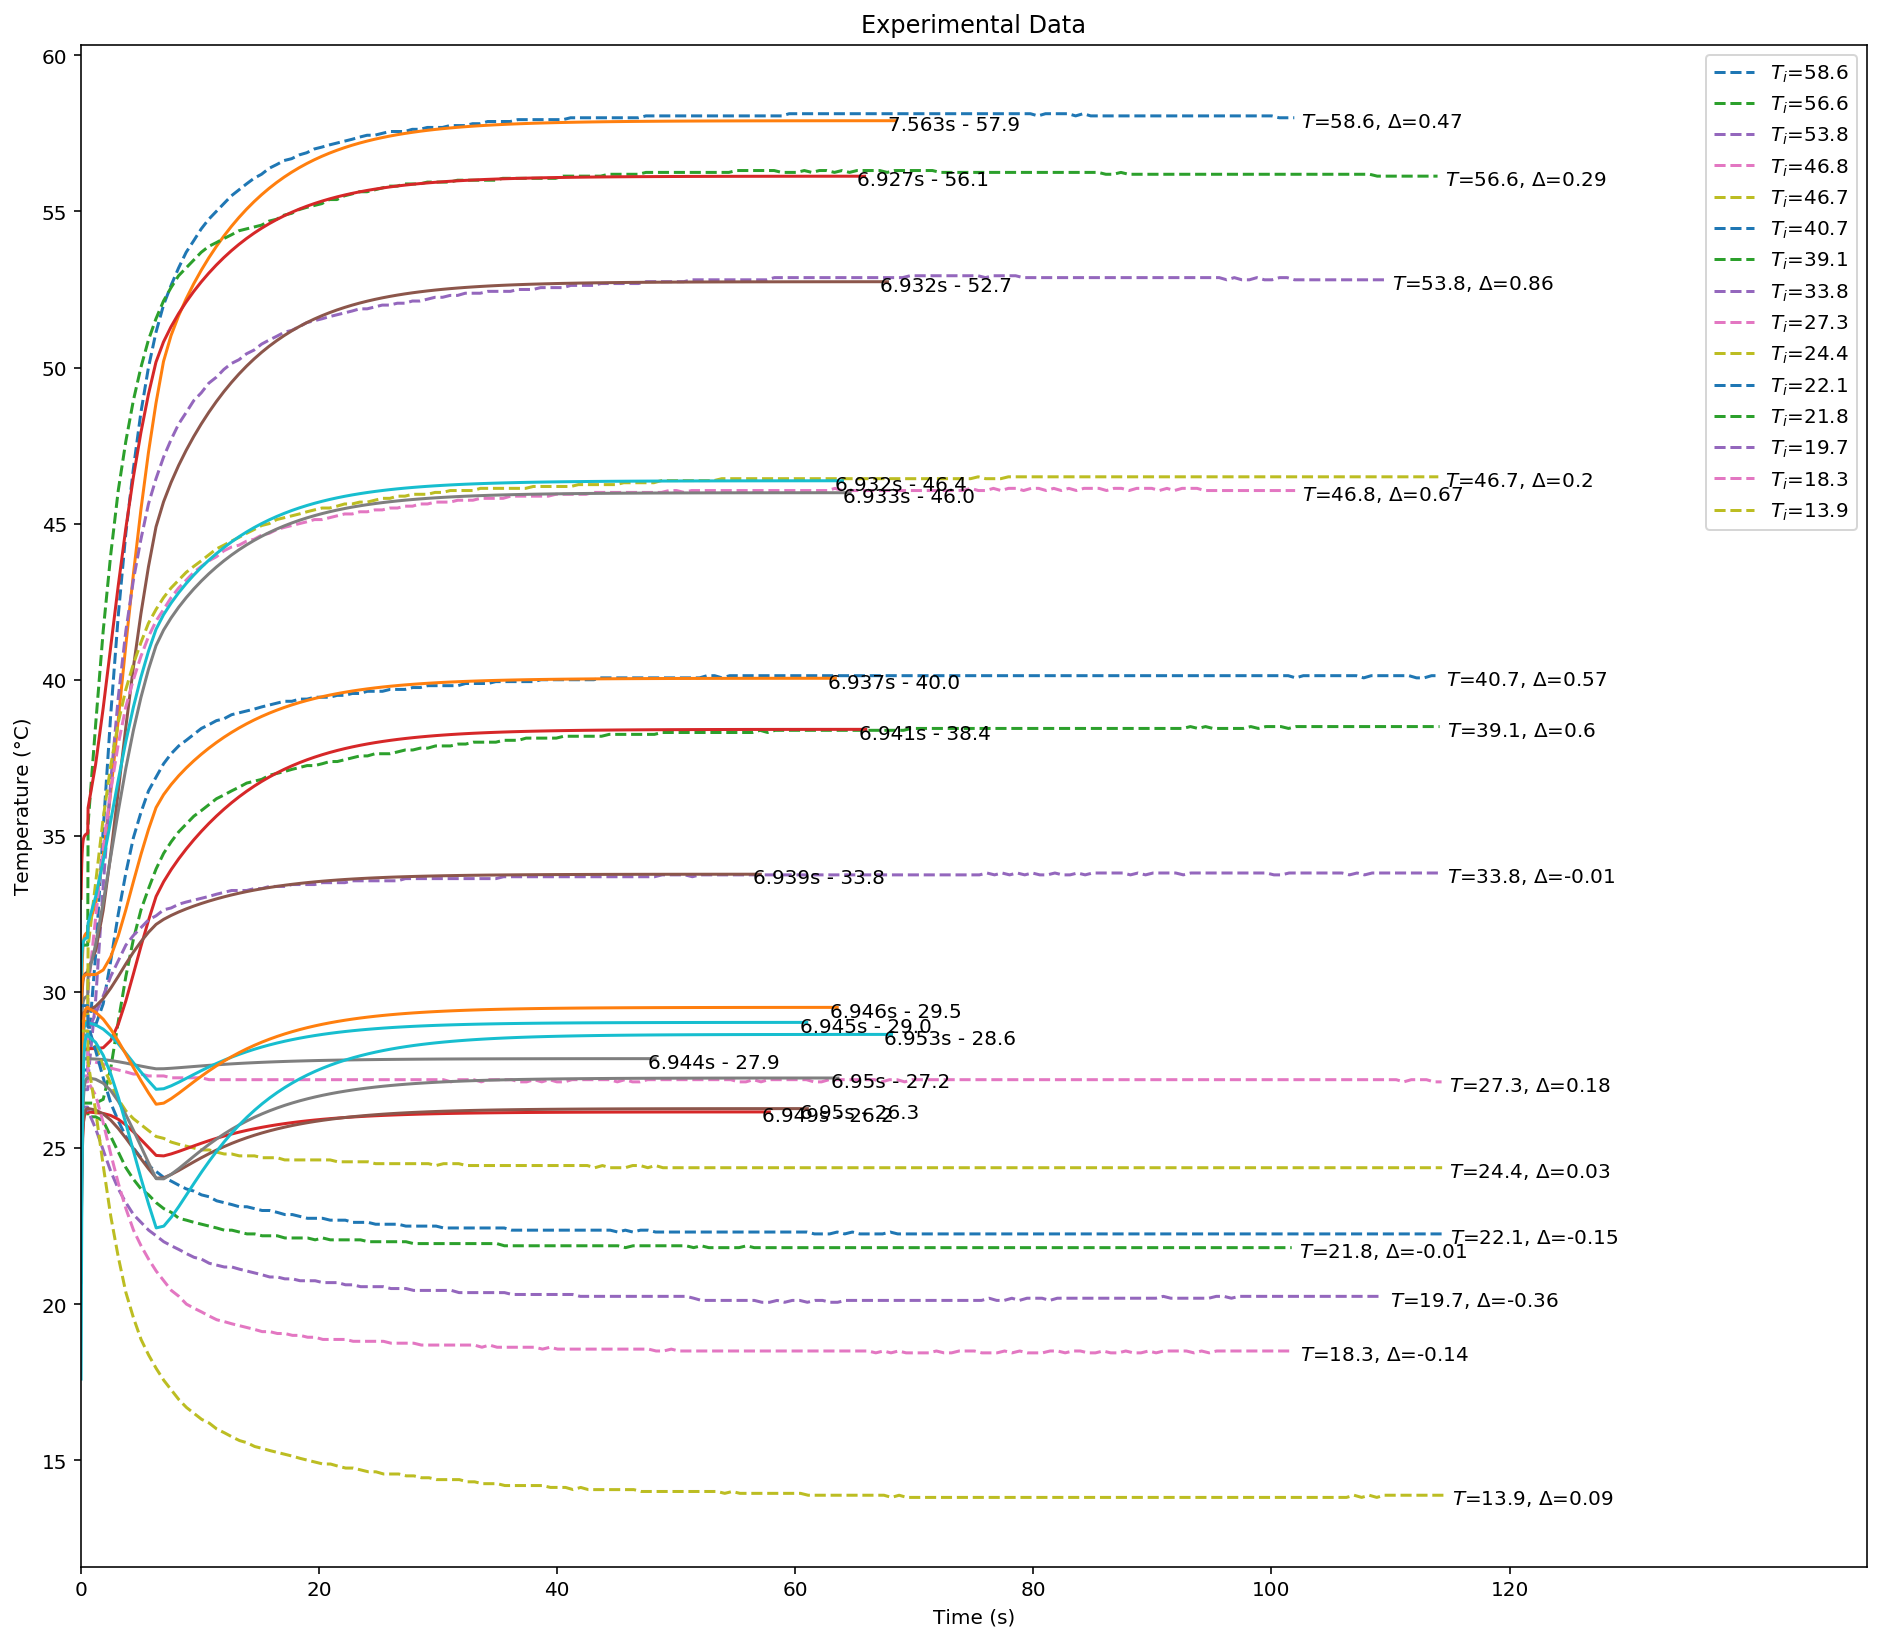

In [16]:
plt.figure(1, figsize=(16, 14))
plt.title("Experimental Data")
plt.xlabel("Time (s)")
plt.xticks(np.arange(0, 130, step=20))
plt.xlim(0,150)
plt.yticks(np.arange(0, 61, step=5))
plt.ylabel("Temperature (°C)")
ordered_experiments = list(data.keys())
ordered_experiments.sort()
pred_constant = 30
for experiment in ordered_experiments[::-1]:
    t, temp = data[experiment]
    print(t[29])
    temp_pred = []
    time_label = str(t[pred_constant])+"s - "
    for T in temp[:pred_constant]:
        T = (T - temp.min())/(temp.max()-temp.min())
        pred = model.predict(np.array([T]).reshape(1,1,1))[0][0]
        temp_pred.append(pred*(temp.max()-temp.min())+temp.min())
    while (abs(temp_pred[-1] - temp_pred[-2]) > 0.0001) and len(temp_pred) < len(temp):
        T = temp_pred[-1]
        T = (T - temp.min())/(temp.max()-temp.min())
        pred = model.predict(np.array([T]).reshape(1,1,1))[0][0]
        temp_pred.append(pred*(temp.max()-temp.min())+temp.min())
    model.reset_states()
    plt.plot(t, temp, '--', label=r"$T_i$="+experiment)
    plt.plot(t[:len(temp_pred)], temp_pred, '-')
    if float(experiment) < 28:
        label = round(float(experiment) - temp.min(), 2)
    else:
        label = round(float(experiment) - temp.max(), 2)
    plt.text(t[-1]+0.6,temp[-1]-0.3, r"$T$="+experiment+r", $\Delta$="+str(label))
    plt.text(t[:len(temp_pred)][-1]-0.6,temp_pred[-1]-0.3, time_label+str(round(temp_pred[-1],1)))
plt.legend()
plt.show()

In [10]:
model.save("lstm.h5")